# Single_cell_analysis

In [133]:
import sys
import os as os
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle as pkl

import scipy as scipy
import scipy.io as spio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.io.matlab import mat_struct
import pickle
import random
random.seed(666)

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=True, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

## Load session data

In [134]:
meta = {}
meta[45] = {'mouse':'3C280', 'ks':'Kilosort_2024-04-12_162032', 'del_units':[594], 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[46] = {'mouse':'3C280', 'ks':'Kilosort_2024-04-12_180855', 'del_units':None, 'vis_mice':np.array(['nan', 'alpha', 'beta'])}
meta[11] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-06_154258', 'del_units':[847, 835, 76,21,15,737,918], 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[13] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_120055', 'del_units':None, 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[14] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_122629', 'del_units':None, 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[19] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_140410', 'del_units':None, 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[20] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-15_110539', 'del_units':[33], 'vis_mice':np.array(['nan', 'beta', 'alpha'])}

In [135]:
# this section for aaa/bbb experiment
# meta = {}
# meta[21] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-15_180443', 'del_units':None, 'vis_mice':np.array(['beta1', 'beta2', 'beta3']), 'active_blocks' : [1,2,3]}
# meta[22] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-08_160558', 'del_units':None, 'vis_mice':np.array(['alpha1', 'alpha2', 'alpha3']), 'active_blocks' : [0,1,2]}

In [136]:
Session = 11 # just put the nb of ur session (should be in meta) and run all code

In [137]:
mouse = meta[Session]['mouse']
ks = meta[Session]['ks']
del_units=meta[Session]['del_units']
vis_mice = meta[Session]['vis_mice']
# active_blocks = meta[Session]['active_blocks'] # this section for aaa/bbb experiment
active_blocks = [1,2,3]

In [138]:
a_idx = np.where(vis_mice=='alpha')[0][0]
b_idx = np.where(vis_mice=='beta')[0][0]
bl_idx=3
if len(active_blocks)>4:
    aa_idx=a_idx+4
    bb_idx=b_idx+4
    bl_idx=3
else:
    aa_idx=a_idx+3
    bb_idx=b_idx+3    

In [139]:
# this section for aaa/bbb experiment
# a_idx = active_blocks[0]
# b_idx = active_blocks[1]
# bl_idx = active_blocks[2]

In [140]:
try:
    os.makedirs(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\single_cell_analysis\\S{Session}')
except:
    pass

### Ephys data

In [141]:
KSdir = f'L:\\everyone\\sharedDATA\\ProcessedDATA\\{mouse}\\{mouse}_S{Session}\\{ks}\\'

spiketimesfile = KSdir+"spike_times.npy"  
spiketimes = np.load(spiketimesfile)  #### all spiketimes as indexes regardless of cluster

clusterfile = KSdir+"spike_clusters.npy"
spikeclusters = np.load(clusterfile) #### cluster id for each detected spike

Clusterinfofile = KSdir+"cluster_info.tsv"
Clusterinfo = pd.read_csv(Clusterinfofile,sep='\t') #### cluster meta-data matrix


######################################################################################################
goodclusts = Clusterinfo['cluster_id'][np.where(Clusterinfo['group']=='good')[0]]
## pandas.Series: | cluster_idx | cluster_id |

goods = [] # list of good cluster_id
for clust in goodclusts :
    goods.append(clust)
print(f'In session {Session} we have {len(goods)} good clusters')

######################################################################################################
goodspiketimes = {}
spikethresh = 1000 # at least defined nb of spikes (if less, it's a piece of shit)

for goodunit in goods : # iterate by good units
    # spike indeces of this good unit
    goodinds = np.where(spikeclusters==goodunit)[0]
    if goodinds.shape[0] > spikethresh : # at least defined nb of spikes
        goodspiketimes[goodunit] = spiketimes[goodinds]

In session 11 we have 40 good clusters


### Behavior data

In [142]:
### 17 interesting behavioral events... Giulio's matlab function!
matfile = f'L:\\everyone\\sharedDATA\\ProcessedDATA\\{mouse}\\{mouse}_S{Session}\\Behaviour.mat'
EvaBehavior = loadmat(matfile)

In [143]:
def load_behavioral_event(event_idx, time_to_idx = True):
    '''
    returns dictionary; keys - blocks; inside - array with event :
    time stamps in [sec] if time_to_idx = False
    indexes if time_to_idx = True
    '''
    event_dic = {}

    for block in np.arange(EvaBehavior['Behaviour'].shape[0]) :
        if time_to_idx:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]*20000
        else:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]
        event_dic[block] = event_dic[block].astype(int)
    
    return event_dic

In [144]:
TestSocialSampleWindowPerTrial = load_behavioral_event(12)

## Trial neuronal activity. Identifying of good units

In [145]:
## find spikes in interesting behavioral window
samplplimg_rate = 20*1000 #20 kHz
beforesamples = 1*samplplimg_rate # 1 sec (expressed in samples for a 20khz sampling rate)
aftersamples = 1*samplplimg_rate # 1 sec
eventlength = 0.25*samplplimg_rate # 0.25 s

# for psth
binsize = 0.05*samplplimg_rate ### 50 ms 
bins = np.linspace(-beforesamples,aftersamples+eventlength,int((beforesamples+aftersamples+eventlength)/binsize)+1)

In [146]:
TestSocialSampleWindowPerTrial.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6])

In [147]:
spikes_dic = {}
psth_dic = {}

for block in active_blocks:
    blockdic = {}
    unitspikes = {}
    eventhists = {}

    n_trials = TestSocialSampleWindowPerTrial[block].shape[0]

    for unit in goodspiketimes.keys(): # list of good cluster_id

        unitspikes[unit] = {}
        eventhists[unit] = np.zeros(bins.shape[0]-1)

        for event in np.arange(n_trials) : #iterate by npoke events

            onset = TestSocialSampleWindowPerTrial[block][event,0]
            offset = TestSocialSampleWindowPerTrial[block][event,1] # for s36: -(0.25*20000) # since window is 500 for some reason
            
            cond1 = np.where(goodspiketimes[unit].astype(int)>=onset-beforesamples)[0]
            cond2 = np.where(goodspiketimes[unit].astype(int)<=offset+aftersamples)[0]
            unitspikes[unit][event] = goodspiketimes[unit][np.intersect1d(cond1,cond2)].astype(int)-onset
            
            # PSTH
            n = np.histogram(unitspikes[unit][event], bins=bins)[0] # count spikes
            eventhists[unit]+=n
        eventhists[unit] = (eventhists[unit]/n_trials)*1/0.05 # Hz
               
    spikes_dic[block] = unitspikes
    psth_dic[block] = eventhists

In [148]:
try:
    for block in active_blocks:
        for unit in del_units:
            del spikes_dic[block][unit]
            del psth_dic[block][unit]
except:
    pass

### Unit psth

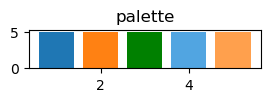

In [149]:
palette = ['#1F77B4', '#FF8113', 'green', '#51a5e1', '#ffa04d']

x = [1, 2, 3, 4, 5]
y = [5,5,5,5,5]

plt.figure(figsize=(3, 0.5))
for i in range(5):
    plt.bar(x[i], y[i], color = palette[i])
plt.title('palette')
plt.show()

In [150]:
psth_zscored_dic = {}

for block in active_blocks:
    bl = {}
    for unit in psth_dic[1].keys():
        try:
            bl[unit] = (psth_dic[block][unit]-np.mean(psth_dic[block][unit]))/np.std(psth_dic[block][unit])
        except:
            bl[unit] = np.nan(len(psth_dic[block][unit]))
    psth_zscored_dic[block] = bl



In [151]:
def psth_trial_activity_v2(blocks, binsize=0.05*samplplimg_rate):

    # sort neurons by Alpha block ====================================================================================
    block = a_idx #alpha

    # window for sorting - 250 ms during npoke
    start = int((beforesamples/binsize)) # beginning of nosepoke
    end = int((beforesamples+eventlength)/binsize)+1

    ## sorting
    neuron_means = {unit: np.mean(psth_zscored_dic[block][unit][start:end]) for unit in psth_zscored_dic[block]}
    sorted_neurons = sorted(neuron_means.items(), key=lambda x: x[1], reverse=True)
    neuron_ids = [neuron[0] for neuron in sorted_neurons]

    # sort ur data
    bins = np.linspace(-beforesamples,aftersamples+eventlength,int((beforesamples+aftersamples+eventlength)/binsize)+1)

    firing_rates = {}
    for block in blocks:  
        firing_rates[block] = [psth_zscored_dic[block][neuron_id] for neuron_id in neuron_ids]
    

    # plot ========================================================================================================

    figsize=(6.5,5)
    block_names=['Alpha','Beta','Blank']
    block_idx = [a_idx,b_idx,bl_idx]
    palette = ['#1F77B4', '#FF8113', 'green']
  
    fig = plt.figure(figsize=figsize)
    x = len(blocks)    

    # 1 block
    plt.subplot(1, x+1, 1)
    im = plt.imshow(firing_rates[a_idx], cmap='cividis', aspect='auto')
    plt.title(block_names[0])
    plt.xlabel('Time (s)')
    plt.ylabel('Cell number (sorted)')
    plt.yticks(np.arange(len(neuron_ids)), neuron_ids, fontsize=7)
    plt.xticks(list(range(0, len(bins)+1, 5)), labels=bins[::5]/20000, fontsize=7, rotation=45)
    # plt.axvspan(beforesamples/binsize, (beforesamples+eventlength)/binsize, color=palette[0], alpha=0.03)
    plt.axvline(x=beforesamples/binsize, color=palette[0], linewidth=1)
    plt.axvline(x=(beforesamples+eventlength)/binsize, color=palette[0], linewidth=1)

    
    for i in range(1,x-1):
        plt.subplot(1, x+1, i+1)
        plt.imshow(firing_rates[block_idx[i]], cmap='cividis', aspect='auto')
        plt.title(block_names[i])
        plt.xlabel('Time (s)')
        plt.ylabel('')
        plt.gca().set_yticklabels([])
        plt.xticks(list(range(0, len(bins)+1, 5)), labels=bins[::5]/20000, fontsize=7, rotation=45)
        # plt.axvspan(beforesamples/binsize, (beforesamples+eventlength)/binsize, color=palette[i], alpha=0.03)
        plt.axvline(x=beforesamples/binsize, color=palette[i], linewidth=1)
        plt.axvline(x=(beforesamples+eventlength)/binsize, color=palette[i], linewidth=1)


    # FILLER BLOCK  
    i = x-1
    plt.subplot(1, x+1, x)
    plt.imshow(firing_rates[block_idx[i]], cmap='cividis', aspect='auto')
    plt.title(block_names[i])
    plt.xlabel('Time (s)')
    plt.ylabel('')
    plt.gca().set_yticklabels([])
    plt.xticks(list(range(0, len(bins)+1, 5)), labels=bins[::5]/20000, fontsize=7, rotation=45)
    # plt.axvspan(beforesamples/binsize, (beforesamples+eventlength)/binsize, color=palette[i], alpha=0.03)
    plt.axvline(x=beforesamples/binsize, color=palette[i], linewidth=1)
    plt.axvline(x=(beforesamples+eventlength)/binsize, color=palette[i], linewidth=1)
    # cbar = plt.colorbar()
    # cbar.set_label('Firing Rate [Hz]')
    if len(blocks)>4:
        cb_ax = fig.add_axes([.85,.16,.01,.5]) #[left, bottom, width, height]
        fig.colorbar(im,orientation='vertical',cax=cb_ax)
        plt.suptitle("z-scored firing rate", x=0.91, y=0.5, fontsize=10, rotation='vertical')
        cb_ax.tick_params(rotation=90)
    else:
        cb_ax = fig.add_axes([.81,.17,.01,.5]) #[left, bottom, width, height]
        fig.colorbar(im,orientation='vertical',cax=cb_ax)
        plt.suptitle("z-scored firing rate", x=0.9, y=0.5, fontsize=10, rotation='vertical')


    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\single_cell_analysis\\S{Session}\\{mouse}_S{Session}_blocks_psth.png', dpi=300, bbox_inches='tight')
    plt.show()

C:\Users\ebukina\AppData\Local\Temp\ipykernel_22072\1453651030.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


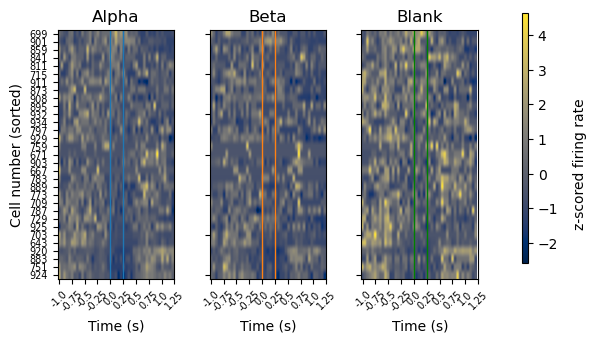

In [152]:
psth_trial_activity_v2(active_blocks)

## Activity of the best neurons in different trials

In [153]:
def best_cell_trial_activity(cell):
    unit = cell

    # prepare data
    bins = np.linspace(-beforesamples,aftersamples+eventlength,int((beforesamples+aftersamples+eventlength)/binsize)+1)

    figsize=(7,3)
    block_names=['Alpha','Beta','Blank']
    block_idx = [a_idx,b_idx,bl_idx]
    palette = ['#1F77B4', '#FF8113', 'green']  
    x=3
    y=1  
  

    plt.figure(figsize=figsize)
    ########################################
    # 1 block
    plt.subplot(y, x, 1)
    offset=0
    event_idx_list = np.arange(TestSocialSampleWindowPerTrial[a_idx].shape[0])
    for event in event_idx_list :
        plt.vlines(list(spikes_dic[a_idx][unit][event]),offset,offset+1, color='black', alpha=0.1)
        plt.vlines(list(spikes_dic[a_idx][unit][event]),offset,offset+1, color='black', alpha=0.1)
        offset+=1
        
    # Min-Max normalization
    psth_minmax = (psth_dic[a_idx][unit] - np.min(psth_dic[a_idx][unit])) / (np.max(psth_dic[a_idx][unit]) - np.min(psth_dic[a_idx][unit]))
    plt.plot((bins[1:]+bins[:-1])/2, psth_minmax*5, color='black')
    plt.axvspan(0, eventlength, color = palette[0], alpha=0.2)
    plt.title(block_names[0], fontsize=10)
    plt.xlabel('')
    plt.xticks(bins[::5], labels=bins[::5]/20000, fontsize=6, rotation=45)
    # plt.yticks(bins[::5], labels=bins[::5]/20000, fontsize=6)
    plt.yticks([0,29], labels=[1,30], fontsize=8)
    plt.xlabel('Time, s',  fontsize=10)
    plt.ylabel('Trial',  fontsize=10)


    for i in range(1,x):
        plt.subplot(y, x, i+1)
        offset=0
        event_idx_list = np.arange(TestSocialSampleWindowPerTrial[block_idx[i]].shape[0])
        for event in event_idx_list :
            plt.vlines(list(spikes_dic[block_idx[i]][unit][event]),offset,offset+1, color='black', alpha=0.1)
            plt.vlines(list(spikes_dic[block_idx[i]][unit][event]),offset,offset+1, color='black', alpha=0.1)
            offset+=1
            
        # Min-Max normalization
        psth_minmax = (psth_dic[block_idx[i]][unit] - np.min(psth_dic[block_idx[i]][unit])) / (np.max(psth_dic[block_idx[i]][unit]) - np.min(psth_dic[block_idx[i]][unit]))
        plt.plot((bins[1:]+bins[:-1])/2, psth_minmax*5, color='black')
        plt.axvspan(0, eventlength, color = palette[i], alpha=0.2)
        plt.title(block_names[i], fontsize=10)
        plt.xlabel('')
        plt.xticks(bins[::5], labels=bins[::5]/20000, fontsize=6, rotation=45)
        plt.ylabel('')
        plt.xlabel('Time, s',  fontsize=10)
        plt.gca().set_yticklabels([])

    ########################################
    # alpha evening block
    i = len(block_idx)-2
    plt.subplot(y, x, i+1)
    offset=0
    event_idx_list = np.arange(TestSocialSampleWindowPerTrial[block_idx[i]].shape[0])
    for event in event_idx_list :
        plt.vlines(list(spikes_dic[block_idx[i]][unit][event]),offset,offset+1, color='black', alpha=0.1)
        plt.vlines(list(spikes_dic[block_idx[i]][unit][event]),offset,offset+1, color='black', alpha=0.1)
        offset+=1
        
    # Min-Max normalization
    psth_minmax = (psth_dic[block_idx[i]][unit] - np.min(psth_dic[block_idx[i]][unit])) / (np.max(psth_dic[block_idx[i]][unit]) - np.min(psth_dic[block_idx[i]][unit]))
    plt.plot((bins[1:]+bins[:-1])/2, psth_minmax*5, color='black')
    plt.axvspan(0, eventlength, color = palette[i], alpha=0.2)
    plt.title(block_names[i], fontsize=10)
    plt.xlabel('Time, s',  fontsize=10)
    plt.xticks(bins[::5], labels=bins[::5]/20000, fontsize=6, rotation=45)
    plt.yticks(fontsize=6)
    plt.ylabel('Trial',  fontsize=10)

    # beta evening block
    i = len(block_idx)-1
    plt.subplot(y, x, i+1)
    offset=0
    event_idx_list = np.arange(TestSocialSampleWindowPerTrial[block_idx[i]].shape[0])
    for event in event_idx_list :
        plt.vlines(list(spikes_dic[block_idx[i]][unit][event]),offset,offset+1, color='black', alpha=0.1)
        plt.vlines(list(spikes_dic[block_idx[i]][unit][event]),offset,offset+1, color='black', alpha=0.1)
        offset+=1
        
    # Min-Max normalization
    psth_minmax = (psth_dic[block_idx[i]][unit] - np.min(psth_dic[block_idx[i]][unit])) / (np.max(psth_dic[block_idx[i]][unit]) - np.min(psth_dic[block_idx[i]][unit]))
    plt.plot((bins[1:]+bins[:-1])/2, psth_minmax*5, color='black')
    plt.axvspan(0, eventlength, color = palette[i], alpha=0.2)
    plt.title(block_names[i], fontsize=10)
    plt.xlabel('Time, s',  fontsize=10)
    plt.xticks(bins[::5], labels=bins[::5]/20000, fontsize=6, rotation=45)
    plt.ylabel('')
    plt.gca().set_yticklabels([])

    #############################################

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Add a title to the entire figure at the left-upper corner
    plt.suptitle(f"Cell {unit}", x=0.05, y=0.99, fontsize=12)

    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\single_cell_analysis\\S{Session}\\{mouse}_S{Session}_cell{unit}.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.show()

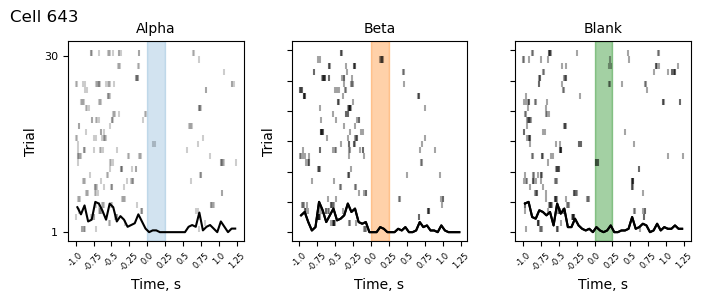

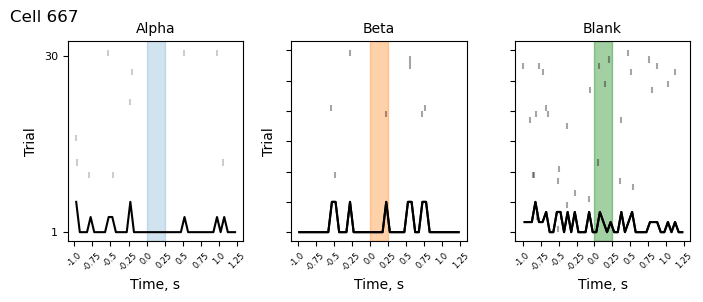

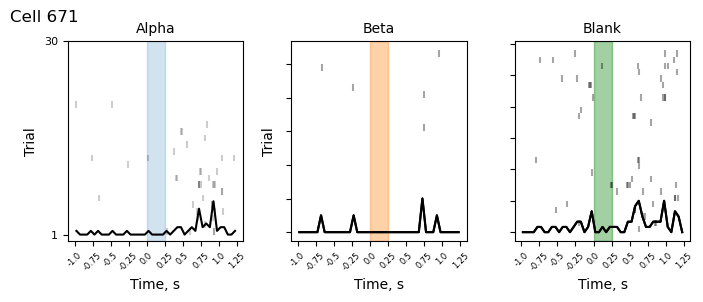

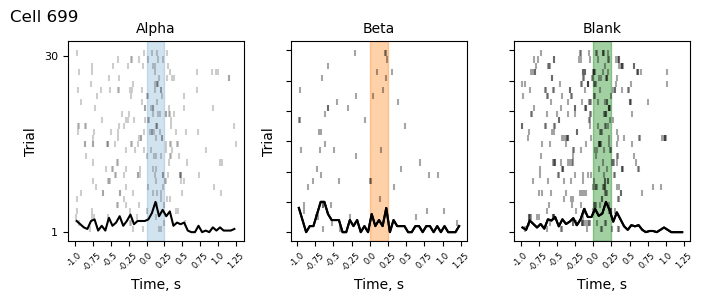

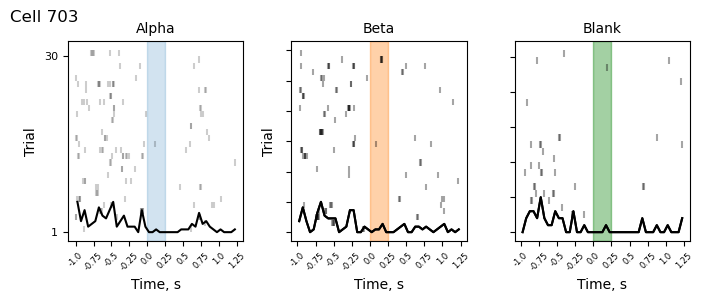

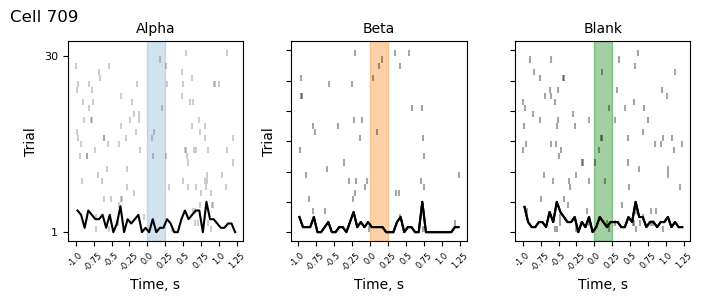

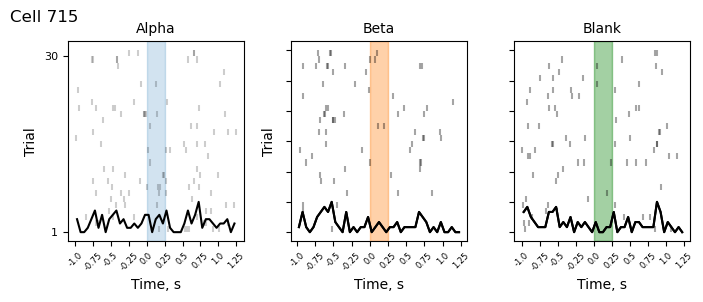

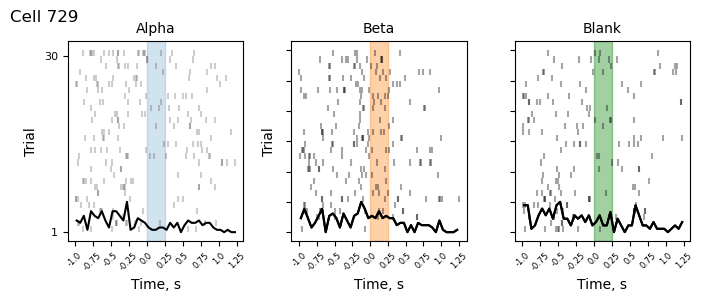

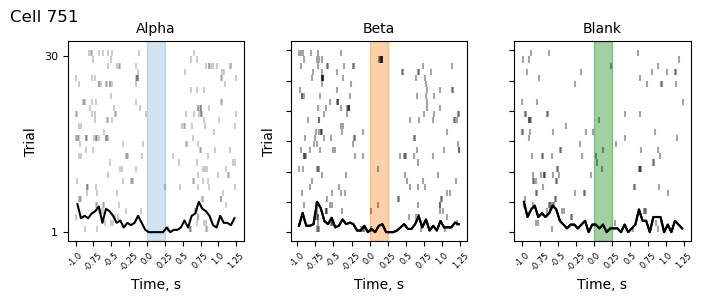

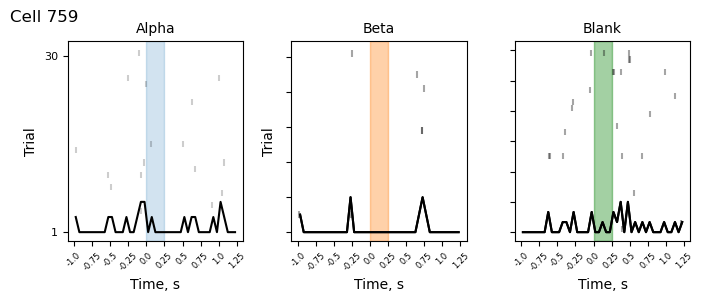

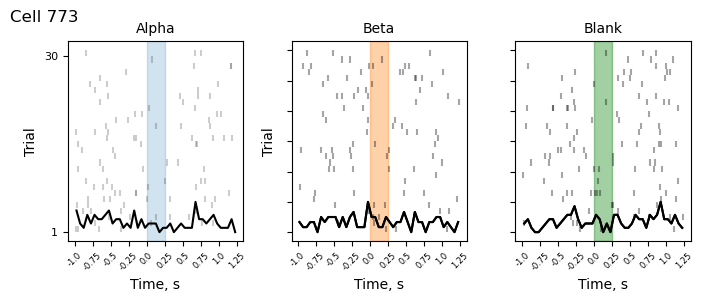

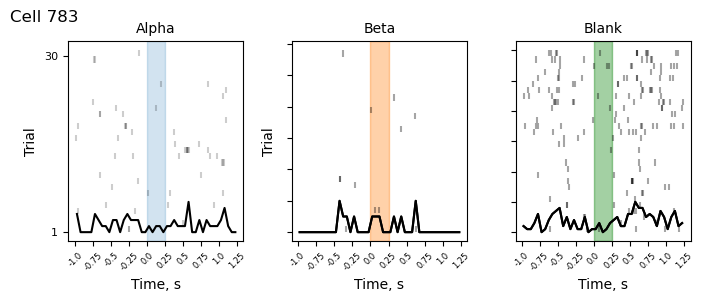

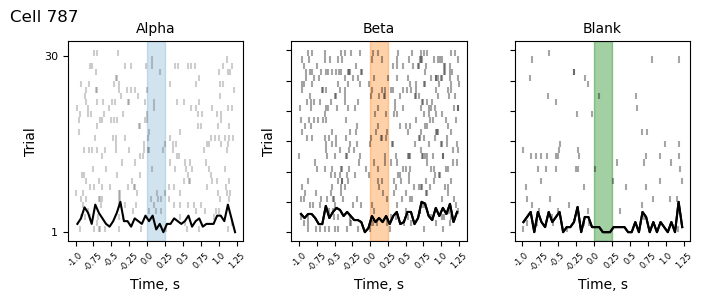

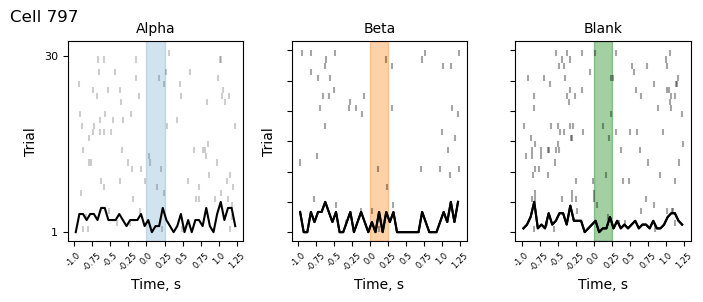

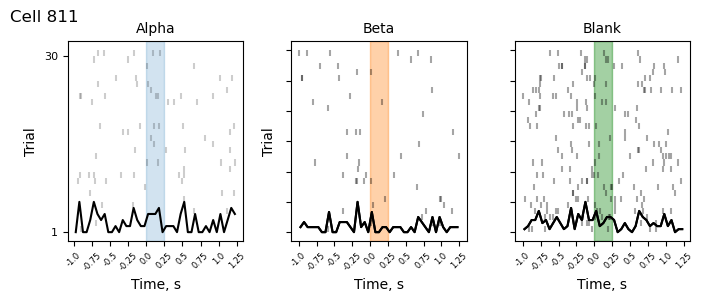

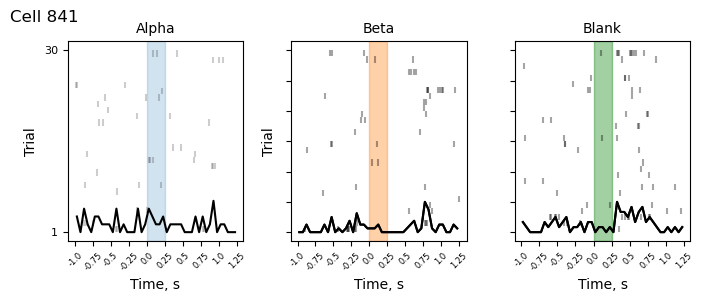

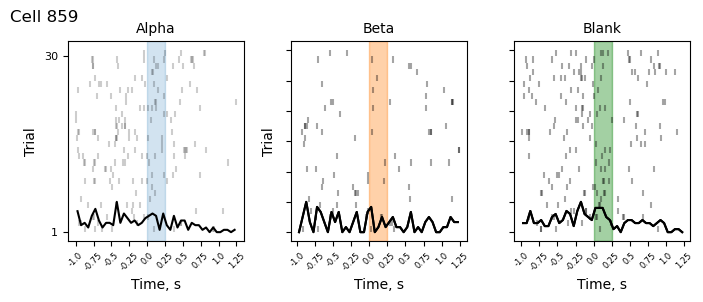

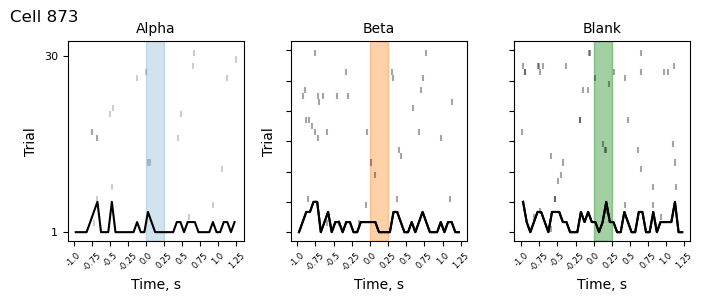

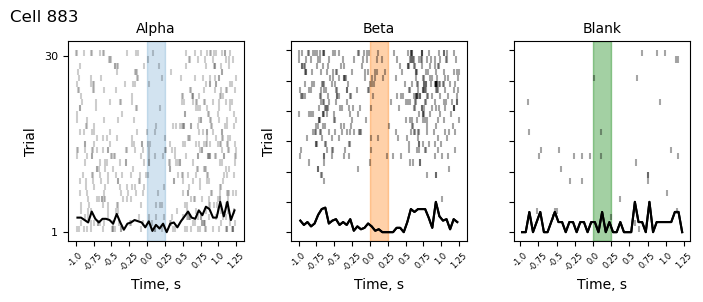

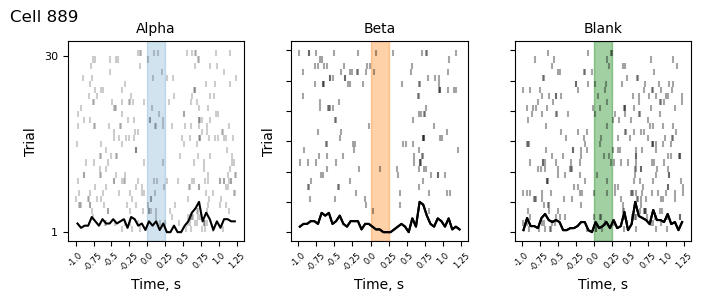

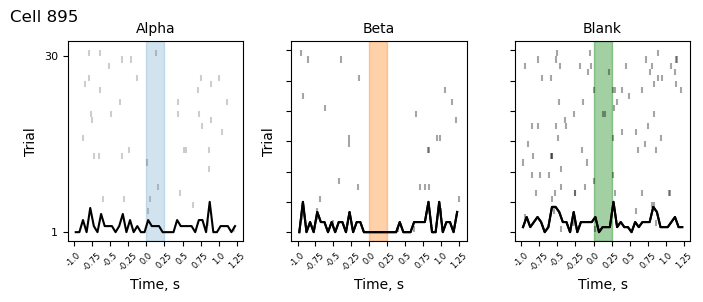

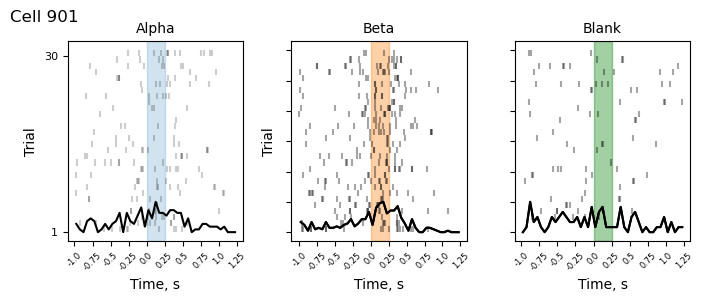

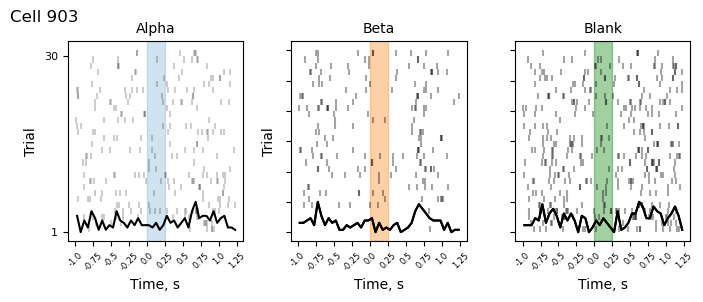

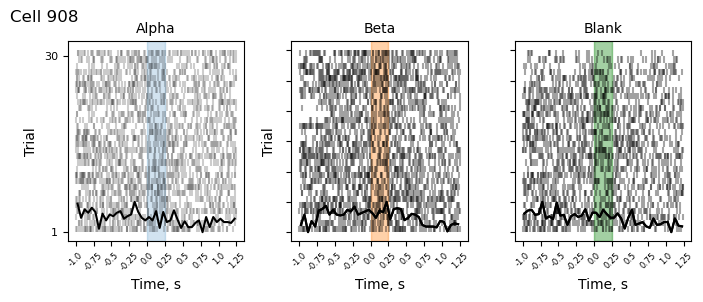

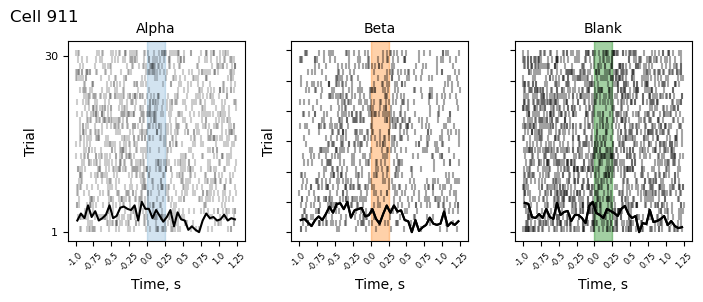

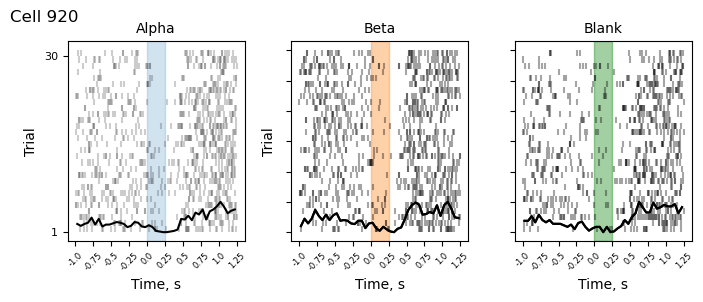

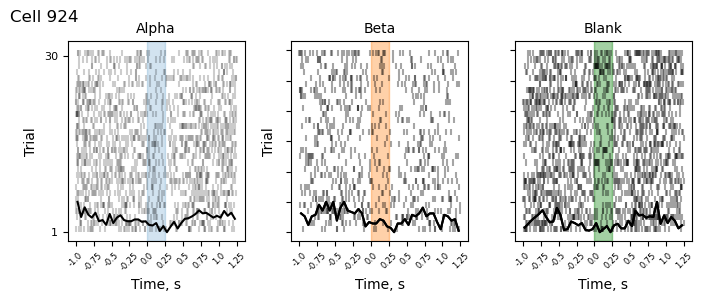

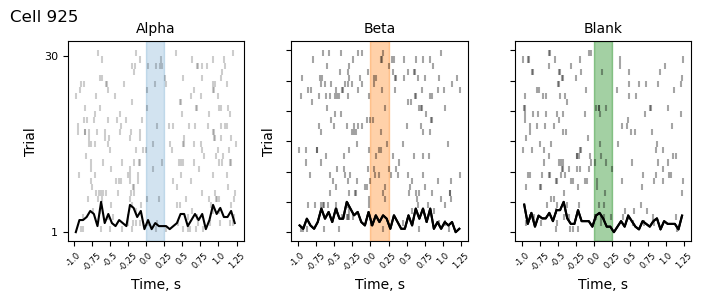

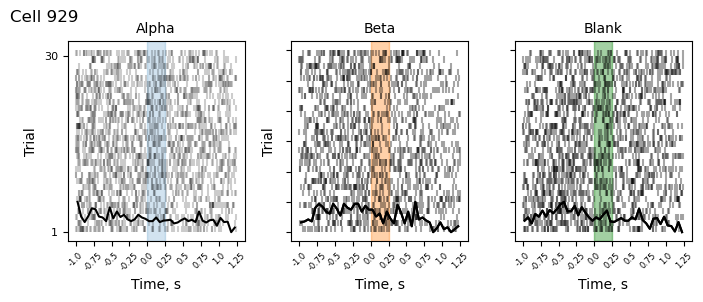

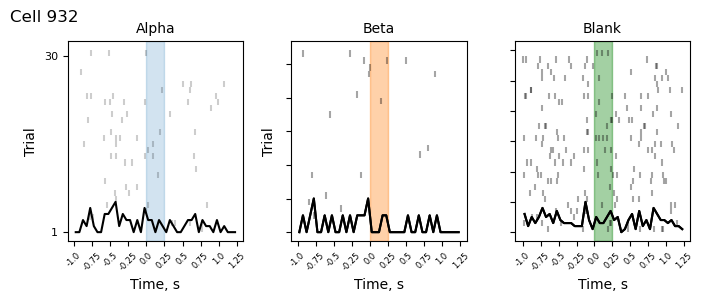

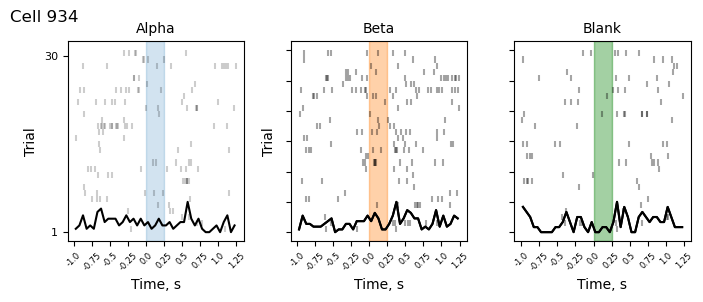

In [154]:
for unit in spikes_dic[1].keys():
    best_cell_trial_activity(unit)